In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Importing libraries
import numpy as np
import pandas as pd

# Importing the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the model building libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# Importing the warning library
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/surprise-housing/train.csv


In [35]:
surprise_df = pd.read_csv("/kaggle/input/surprise-housing/train.csv")
surprise_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [36]:
surprise_df.shape

(1460, 81)

In [37]:
surprise_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning 

In [38]:
# Removing null values or imputing missing values 

def cols_with_missing_values():
    total = surprise_df.isnull().sum().sort_values(ascending=False)
    percent = round(surprise_df.isnull().sum()*100/len(surprise_df), 2).sort_values(ascending=False)
    
    all_features = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    all_features = all_features[all_features.Total != 0]
    
    if len(all_features) == 0:
        return 'No Column with Missing Values.'
    return all_features
   
# Printing columns with null values
cols_with_missing_values()

Total  Percent
PoolQC         1453    99.52
MiscFeature    1406    96.30
Alley          1369    93.77
Fence          1179    80.75
FireplaceQu     690    47.26
LotFrontage     259    17.74
GarageYrBlt      81     5.55
GarageCond       81     5.55
GarageType       81     5.55
GarageFinish     81     5.55
GarageQual       81     5.55
BsmtFinType2     38     2.60
BsmtExposure     38     2.60
BsmtQual         37     2.53
BsmtCond         37     2.53
BsmtFinType1     37     2.53
MasVnrArea        8     0.55
MasVnrType        8     0.55
Electrical        1     0.07

In [39]:
# Dropping columns which have more then 80% null values 
# Dropping column with a lot of missing values
surprise_df.drop(columns=["PoolQC","MiscFeature","Alley","Fence"], inplace=True)
surprise_df.info

<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0        1          60       RL         65.0     8450   Pave      Reg   
1        2          20       RL         80.0     9600   Pave      Reg   
2        3          60       RL         68.0    11250   Pave      IR1   
3        4          70       RL         60.0     9550   Pave      IR1   
4        5          60       RL         84.0    14260   Pave      IR1   
...    ...         ...      ...          ...      ...    ...      ...   
1455  1456          60       RL         62.0     7917   Pave      Reg   
1456  1457          20       RL         85.0    13175   Pave      Reg   
1457  1458          70       RL         66.0     9042   Pave      Reg   
1458  1459          20       RL         68.0     9717   Pave      Reg   
1459  1460          20       RL         75.0     9937   Pave      Reg   

     LandContour Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0         

In [40]:
# impute rest of the column with 'None' word where it is applicable
cols_list = ["FireplaceQu", "GarageCond", "GarageType", 
          "GarageFinish", "GarageQual", "BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtFinType1",
          "BsmtCond", "MasVnrType"]

for col in cols_list:
    surprise_df[col].fillna("None", inplace=True)
    
cols_with_missing_values()

Total  Percent
LotFrontage    259    17.74
GarageYrBlt     81     5.55
MasVnrArea       8     0.55
Electrical       1     0.07

In [41]:
col_list_for_median = ["GarageYrBlt", "MasVnrArea", "LotFrontage"]

for col in col_list_for_median:
    surprise_df[col].fillna(surprise_df[col].median(), inplace=True)
cols_with_missing_values()


Total  Percent
Electrical      1     0.07

In [42]:
surprise_df.dropna(inplace=True)
cols_with_missing_values()

'No Column with Missing Values.'

# Data Analysis

In [43]:
# Dropping ID column as it is not required
surprise_df.drop(columns=["Id"], inplace=True)

surprise_df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1459.000000  1459.000000    1459.000000  1459.000000  1459.000000   
mean     56.881426    69.861549   10517.363948     6.100069     5.575737   
std      42.310746    22.035077    9984.666267     1.383171     1.113079   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7549.000000     5.000000     5.000000   
50%      50.000000    69.000000    9477.000000     6.000000     5.000000   
75%      70.000000    79.000000   11603.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1459.000000   1459.000000  1459.000000  1459.000000  1459.000000  ...   
mean   1971.244003   1984.850583   103.187800   443.943797    46.581220  ...   
std      30.199555     20.644343   180.773158   456.106417   161.369977  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   384.000000     0.000000  ...   
75%    2000.000000   2004.000000   164.500000   712.500000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1459.000000  1459.000000    1459.000000  1459.000000  1459.000000   
mean     94.240576    46.692255      21.969157     3.411926    15.071282   
std     125.381679    66.267472      61.137400    29.327247    55.775138   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1459.000000   1459.000000  1459.000000  1459.000000    1459.000000  
mean      2.760795     43.518849     6.322824  2007.815627  180930.394791  
std      40.191018    496.291826     2.704331     1.328542   79468.964025  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129950.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

In [44]:
surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1459 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

In [45]:
# Making a dataframe with numeric values only 
surprise_numeric_df = surprise_df.select_dtypes(include=['float64', 'int64'])
surprise_numeric_df.shape


(1459, 37)

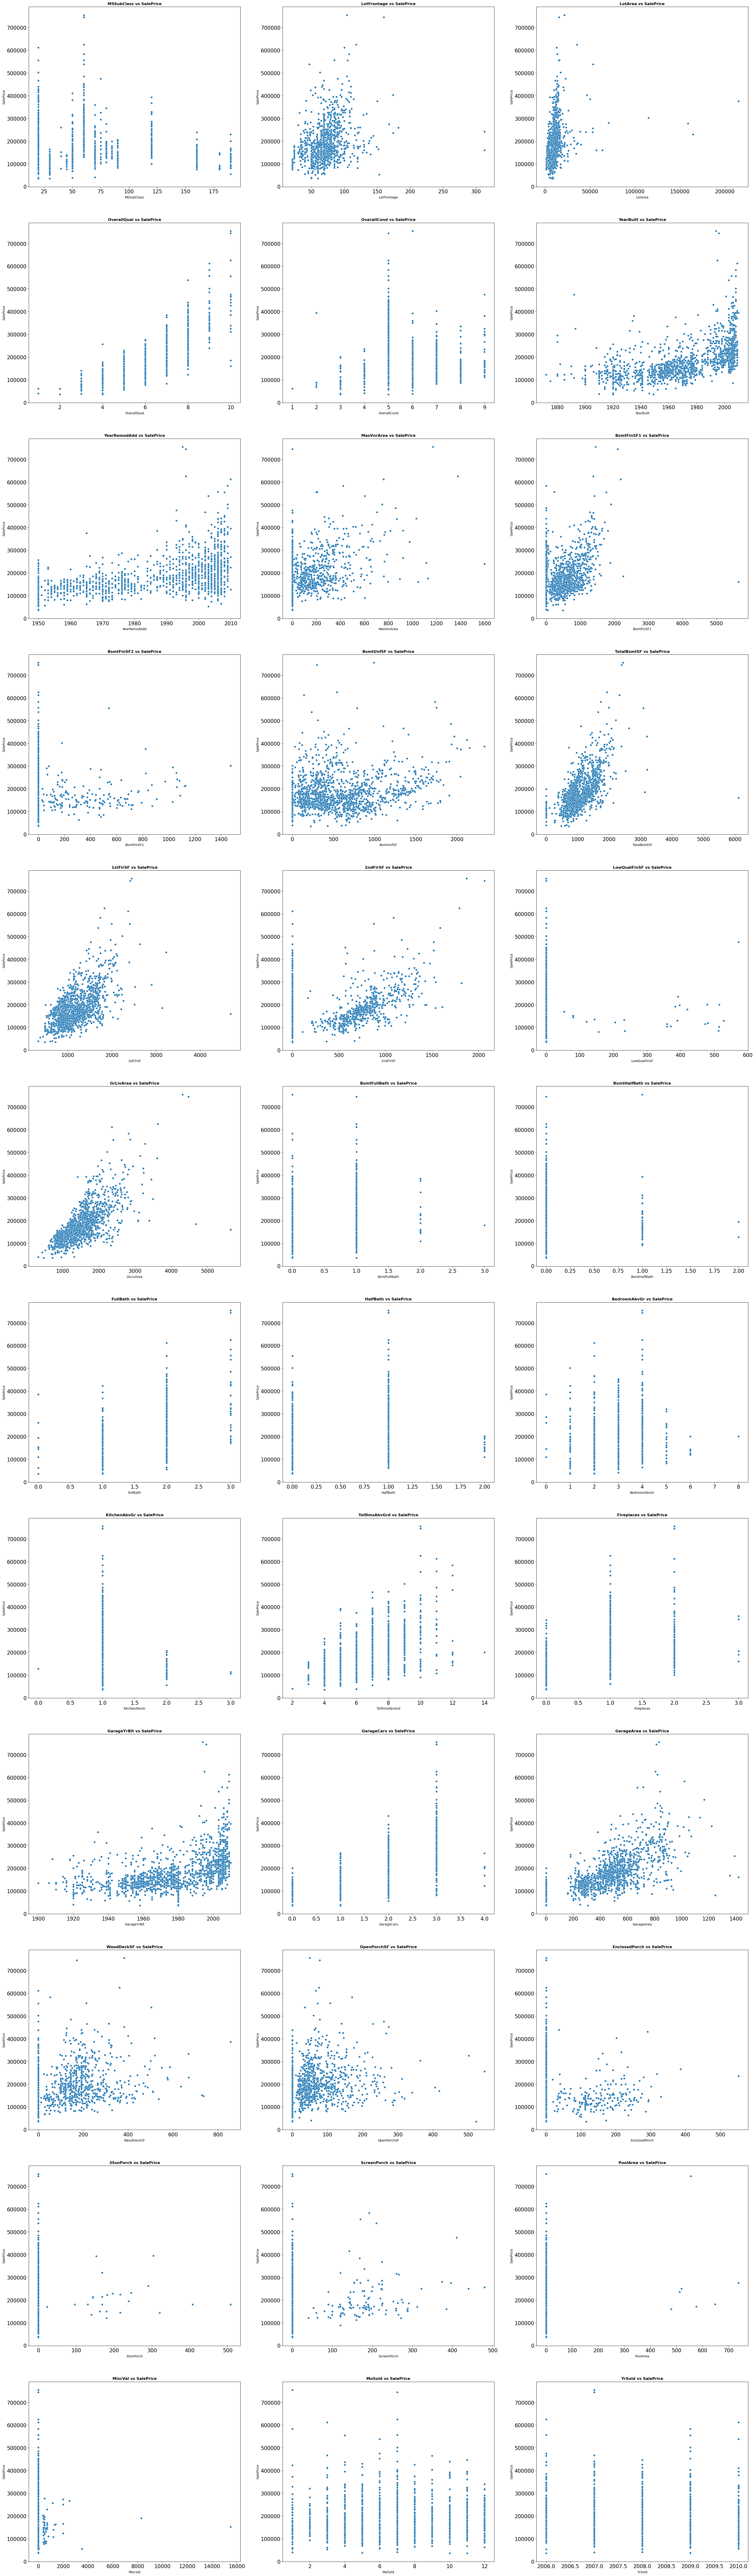

In [46]:
# plotting scattered graphs for numeric data 

plt.figure(figsize=(40, 300))

count = 1

for column in surprise_numeric_df.columns:
    if column != 'SalePrice':
        plt.subplot(25, 3, count)
        sns.scatterplot(surprise_numeric_df, x= column, y= "SalePrice")
        plt.title(column + " vs " + "SalePrice", weight='bold')
        count += 1
    
plt.show()

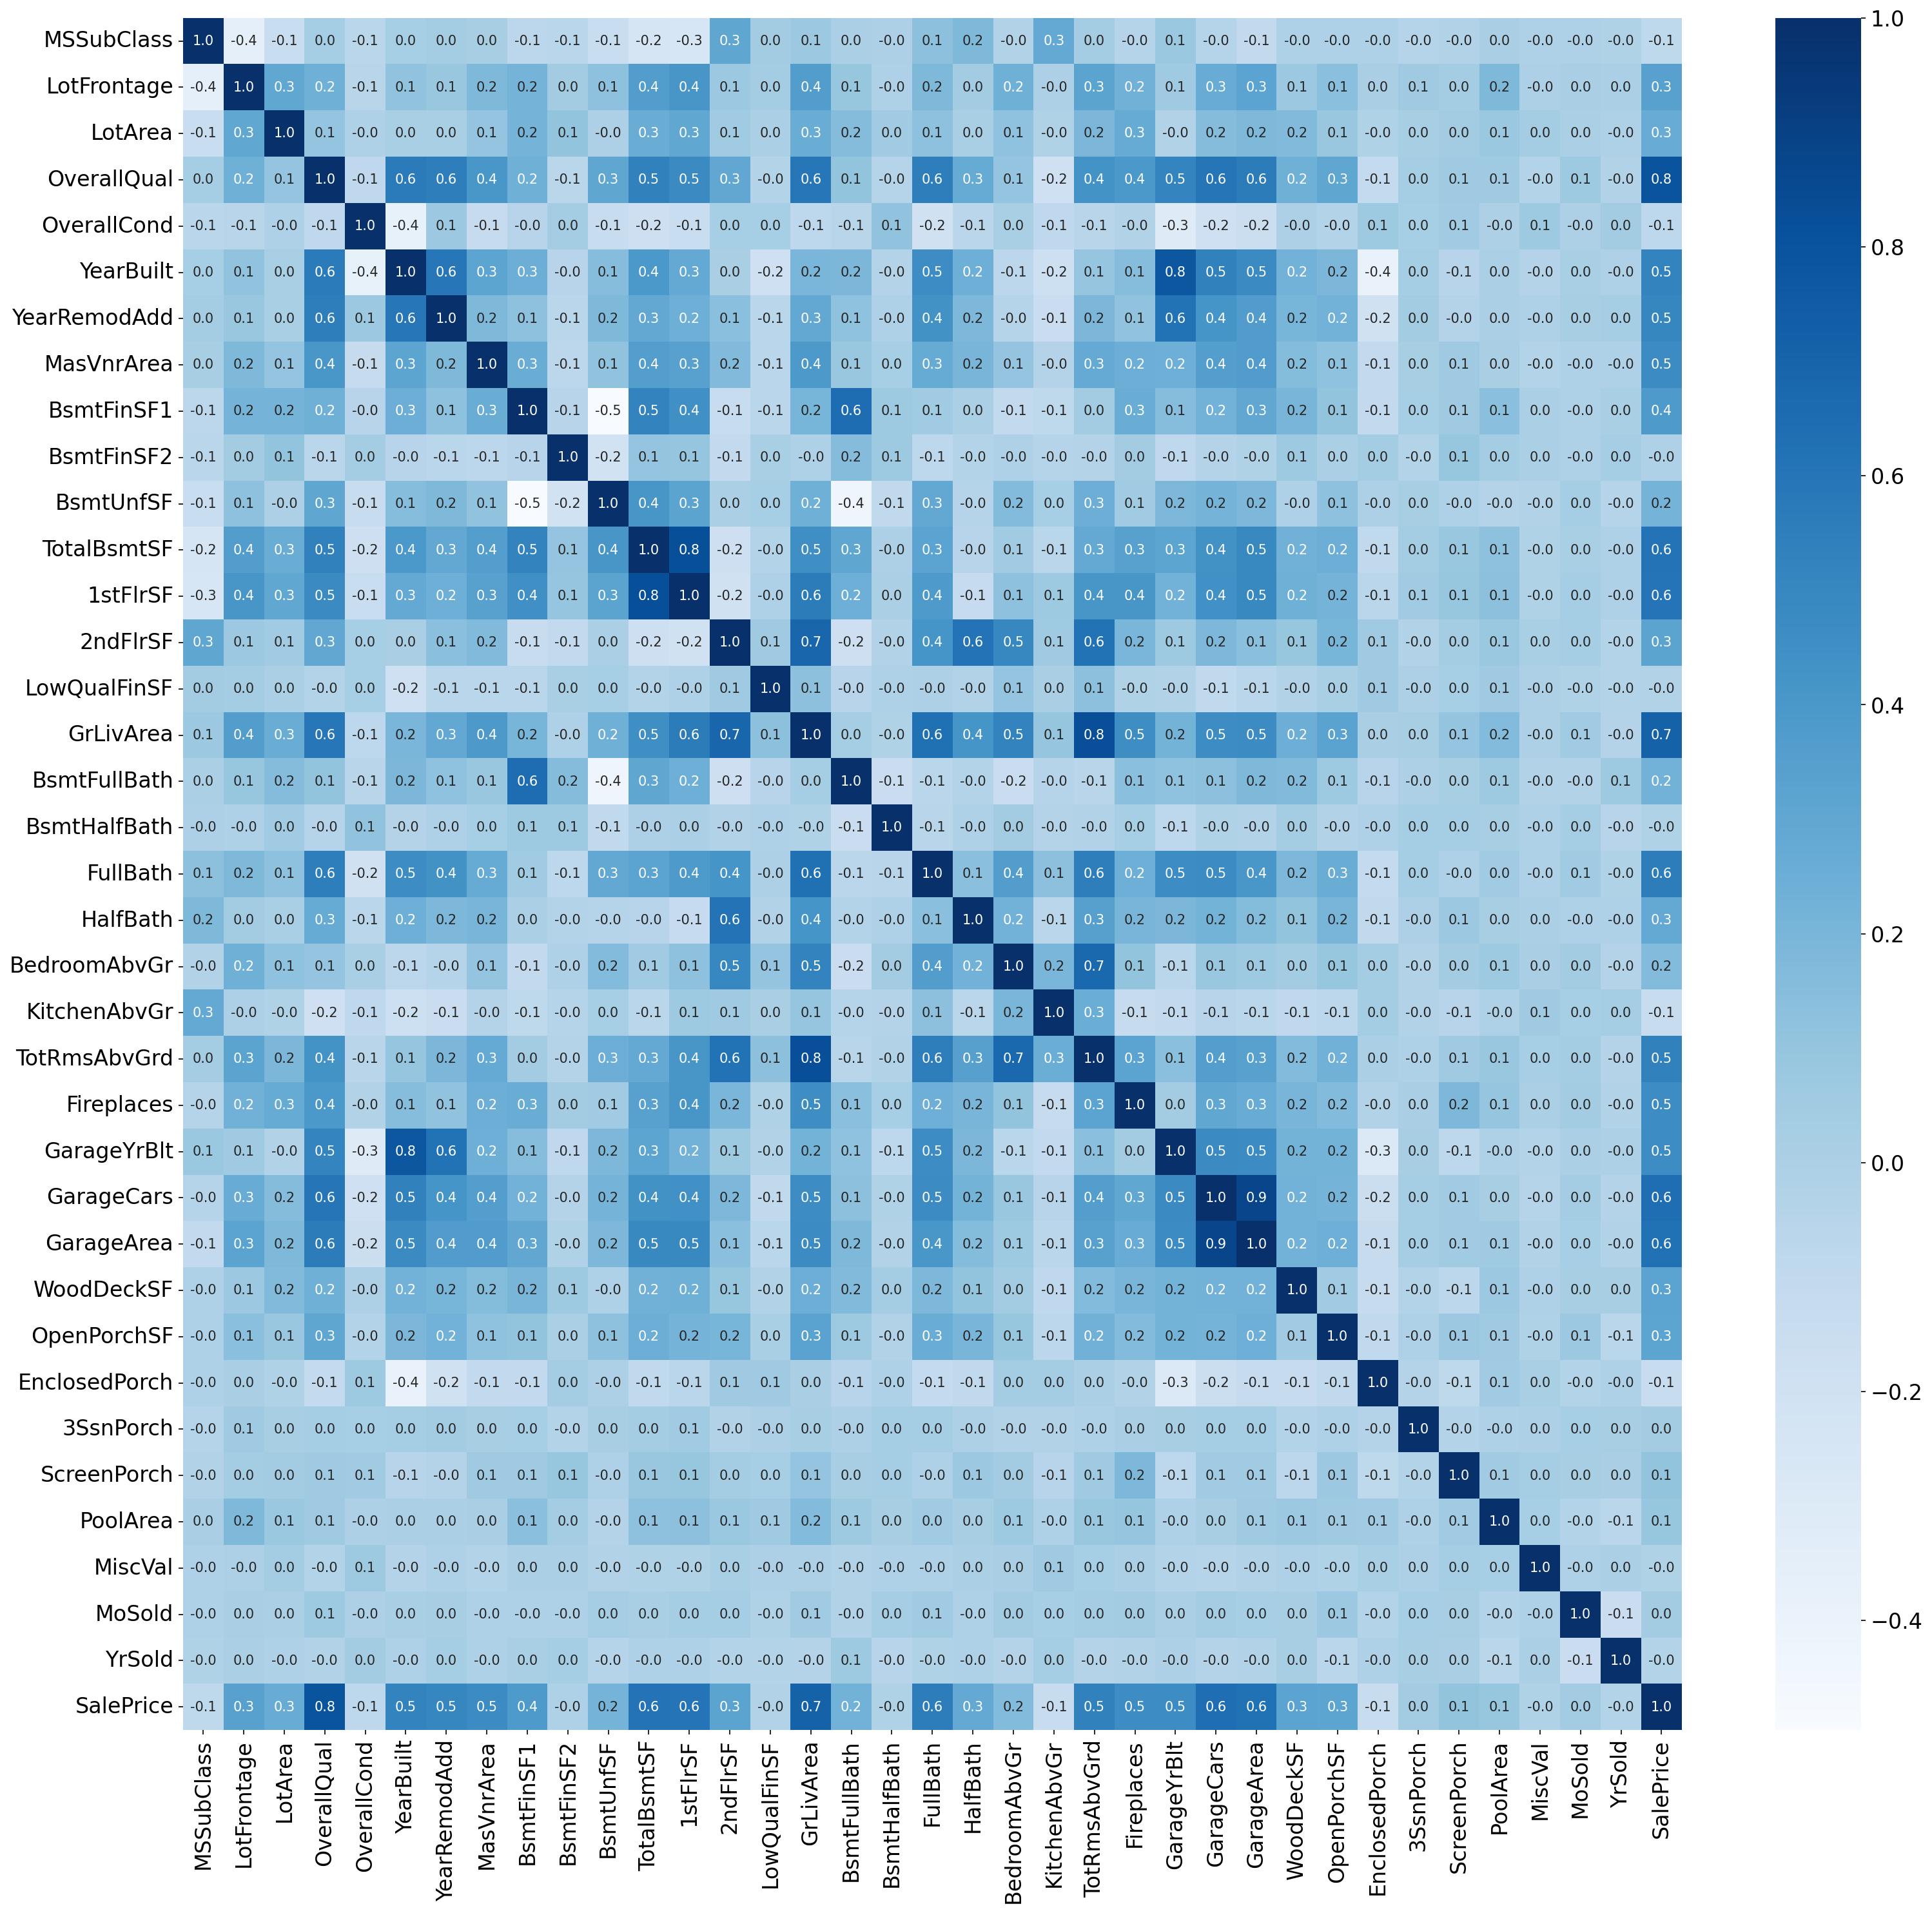

In [47]:
fig = plt.figure(figsize=(25,23),dpi=150)

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

sns.heatmap(surprise_numeric_df.corr(), annot = True, cmap="Blues",fmt='.1f')
plt.show()

In [48]:
surprise_obj_df = surprise_df.select_dtypes(exclude=['float64', 'int64'])
print("Shape :", surprise_obj_df.shape)

surprise_obj_df.info()

Shape : (1459, 39)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1459 non-null   object
 1   Street         1459 non-null   object
 2   LotShape       1459 non-null   object
 3   LandContour    1459 non-null   object
 4   Utilities      1459 non-null   object
 5   LotConfig      1459 non-null   object
 6   LandSlope      1459 non-null   object
 7   Neighborhood   1459 non-null   object
 8   Condition1     1459 non-null   object
 9   Condition2     1459 non-null   object
 10  BldgType       1459 non-null   object
 11  HouseStyle     1459 non-null   object
 12  RoofStyle      1459 non-null   object
 13  RoofMatl       1459 non-null   object
 14  Exterior1st    1459 non-null   object
 15  Exterior2nd    1459 non-null   object
 16  MasVnrType     1459 non-null   object
 17  ExterQual      1459 non-null   object
 18  ExterCond

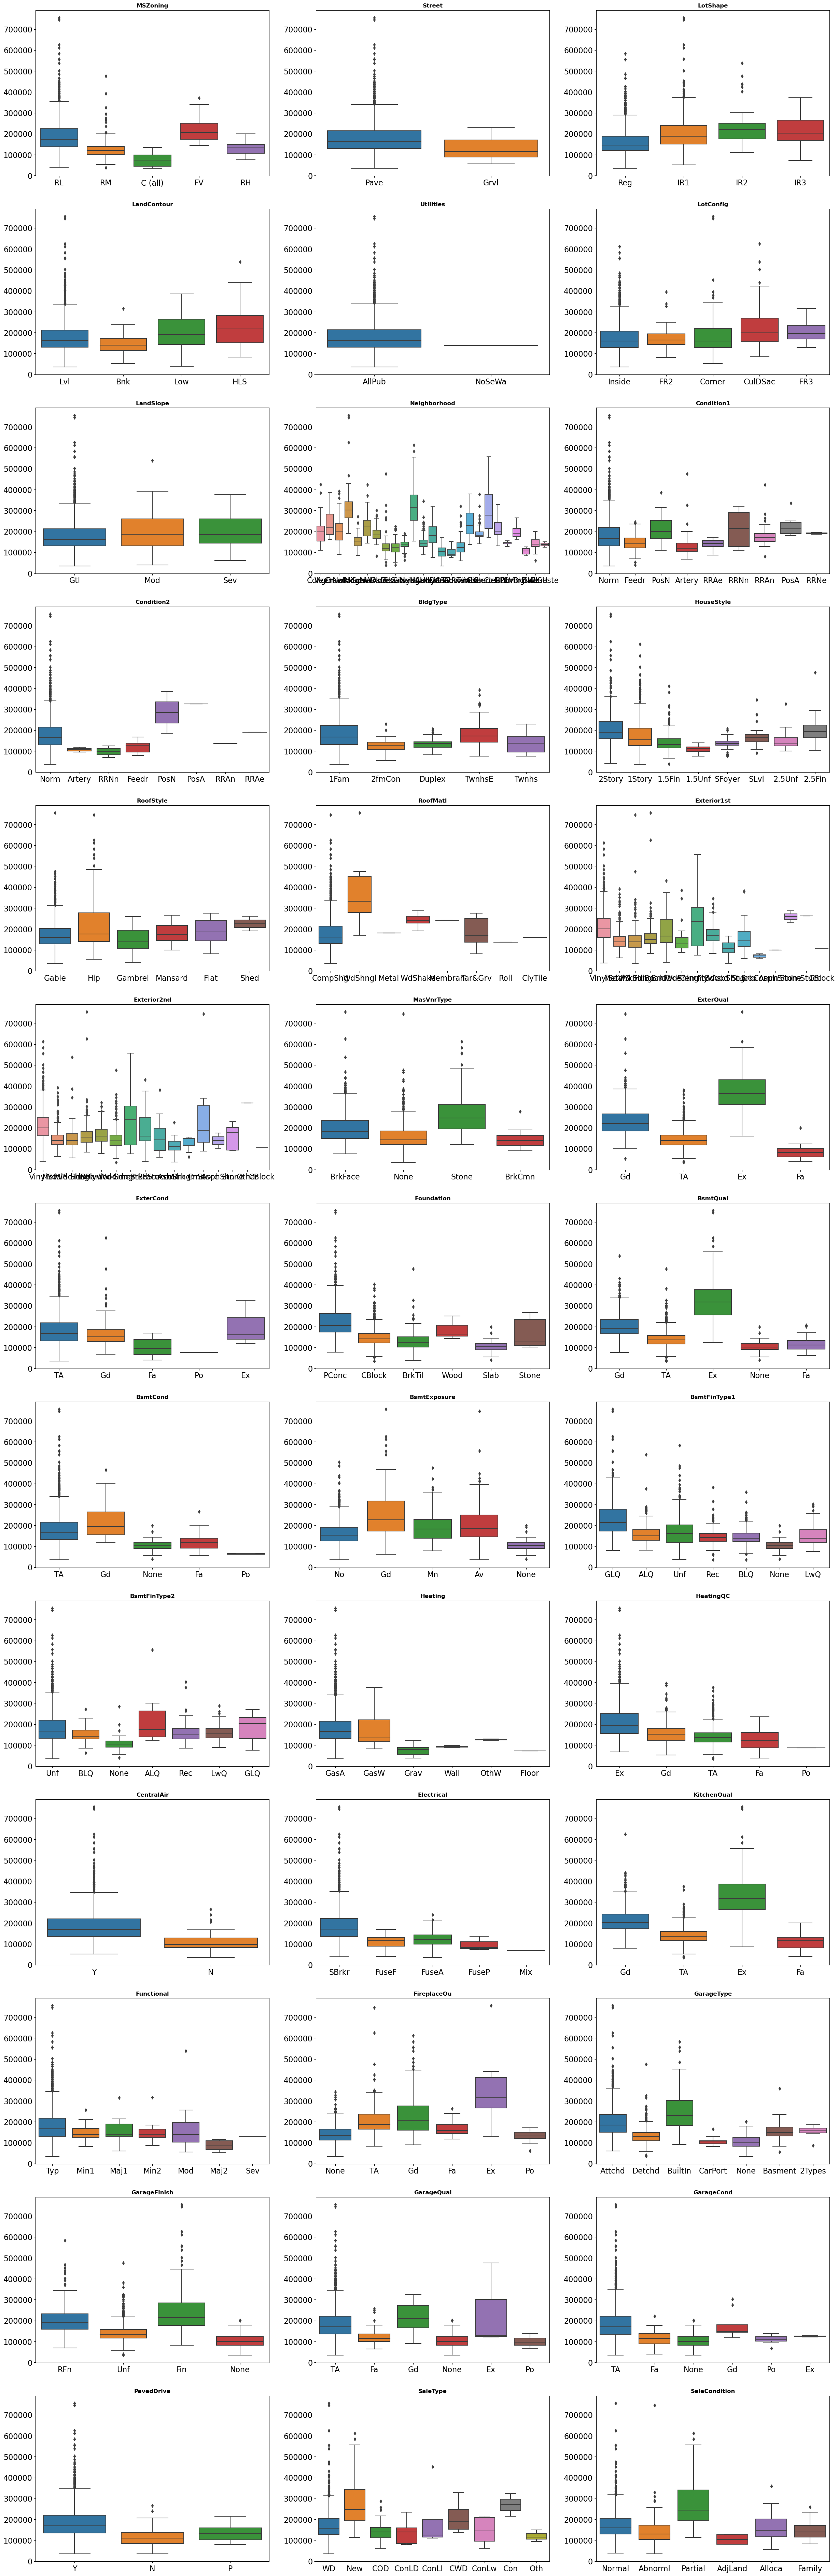

In [49]:
plt.figure(figsize=(30, 150))

count = 1

for column in surprise_obj_df.columns:
    if column != 'SalePrice':
        plt.subplot(20, 3, count)
        sns.boxplot(x=surprise_obj_df[column], y=surprise_df['SalePrice']).set(ylabel=None, xlabel=None)
        plt.title(column, weight='bold')
        count += 1
    
plt.show()

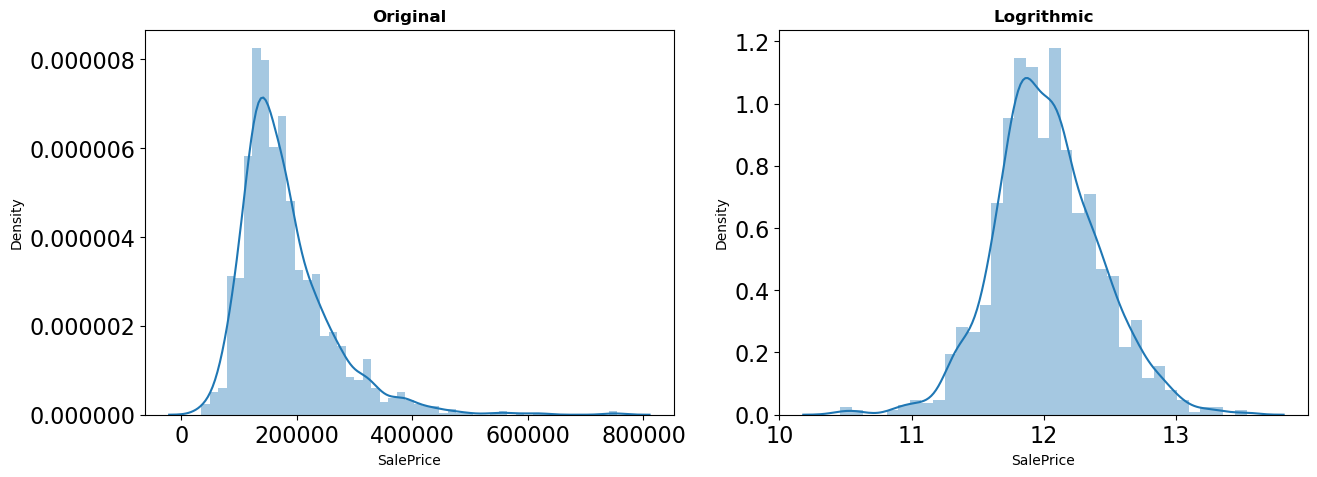

In [50]:
# Target variable data analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.distplot(surprise_numeric_df['SalePrice']).ticklabel_format(useOffset=False, style='plain')
plt.title("Original", weight='bold')

plt.subplot(1, 2, 2)
sns.distplot(np.log(surprise_numeric_df['SalePrice']))
plt.title("Logrithmic", weight='bold')

plt.show()

In [51]:
#Transform saleprice column


surprise_numeric_df['log_SalePrice'] = np.log(surprise_numeric_df['SalePrice'])
surprise_numeric_df[['SalePrice', 'log_SalePrice']].head()


SalePrice  log_SalePrice
0     208500      12.247694
1     181500      12.109011
2     223500      12.317167
3     140000      11.849398
4     250000      12.429216

In [52]:
surprise_dummies = pd.get_dummies(surprise_obj_df, drop_first=True)
print("Shape", surprise_dummies.shape)

surprise_dummies.head()

Shape (1459, 210)


MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  \
0            0            0            1            0            1   
1            0            0            1            0            1   
2            0            0            1            0            1   
3            0            0            1            0            1   
4            0            0            1            0            1   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_HLS  LandContour_Low  \
0             0             0             1                0                0   
1             0             0             1                0                0   
2             0             0             0                0                0   
3             0             0             0                0                0   
4             0             0             0                0                0   

   ...  SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
0  ...               0               0             0             0   
1  ...               0               0             0             0   
2  ...               0               0             0             0   
3  ...               0               0             0             0   
4  ...               0               0             0             0   

   SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
0            1                      0                     0   
1            1                      0                     0   
2            1                      0                     0   
3            1                      0                     0   
4            1                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 210 columns]

In [53]:
# Making the final clean dataset to build the model 
surprise_final_df=pd.concat([surprise_numeric_df, surprise_dummies],axis=1)
surprise_final_df.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0          2003       196.0         706           0  ...               0   
1          1976         0.0         978           0  ...               0   
2          2002       162.0         486           0  ...               0   
3          1970         0.0         216           0  ...               0   
4          2000       350.0         655           0  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 248 columns]

## Scaling the data

In [54]:
# Scaling the numeric data
scaler = StandardScaler()
cols = list(surprise_final_df.columns.values)
cols.remove('SalePrice')
cols.remove('log_SalePrice')

surprise_final_df[cols] = scaler.fit_transform(surprise_final_df[cols])
surprise_final_df.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073732    -0.220703 -0.207125     0.650852    -0.517424   1.051899   
1   -0.871979     0.460263 -0.091909    -0.072372     2.178727   0.157540   
2    0.073732    -0.084510  0.073401     0.650852    -0.517424   0.985650   
3    0.310159    -0.447692 -0.096918     0.650852    -0.517424  -1.863050   
4    0.073732     0.641854  0.374967     1.374077    -0.517424   0.952526   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0      0.879449    0.513594    0.574748    -0.28876  ...       -0.058641   
1     -0.428864   -0.571009    1.171304    -0.28876  ...       -0.058641   
2      0.830993    0.325449    0.092239    -0.28876  ...       -0.058641   
3     -0.719600   -0.571009   -0.499931    -0.28876  ...       -0.058641   
4      0.734081    1.365783    0.462893    -0.28876  ...       -0.058641   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0       -0.058641     -0.302075     -0.045392     0.390447   
1       -0.058641     -0.302075     -0.045392     0.390447   
2       -0.058641     -0.302075     -0.045392     0.390447   
3       -0.058641     -0.302075     -0.045392     0.390447   
4       -0.058641     -0.302075     -0.045392     0.390447   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0              -0.052432             -0.091066             -0.117892   
1              -0.052432             -0.091066             -0.117892   
2              -0.052432             -0.091066             -0.117892   
3              -0.052432             -0.091066             -0.117892   
4              -0.052432             -0.091066             -0.117892   

   SaleCondition_Normal  SaleCondition_Partial  
0              0.467847               -0.30611  
1              0.467847               -0.30611  
2              0.467847               -0.30611  
3             -2.137452               -0.30611  
4              0.467847               -0.30611  

[5 rows x 248 columns]

## Model Building 

In [68]:
y = surprise_final_df[['log_SalePrice']]
X = surprise_final_df.drop(['log_SalePrice', 'SalePrice'], axis = 1)
X.shape


(1459, 246)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

## Lasso

In [71]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True, 
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [72]:
# CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['params', 'mean_train_score', 'mean_test_score']].head()

params  mean_train_score  mean_test_score
0  {'alpha': 0.0001}         -0.061046        -0.105310
1   {'alpha': 0.001}         -0.065443        -0.099362
2    {'alpha': 0.01}         -0.086339        -0.101649
3    {'alpha': 0.05}         -0.126283        -0.129044
4     {'alpha': 0.1}         -0.164189        -0.166083

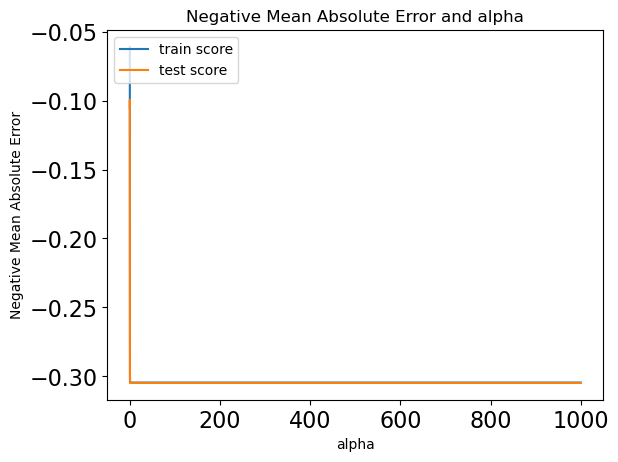

In [73]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [74]:
# Best alpha value
model_cv.best_params_

{'alpha': 0.001}

In [75]:
# Lasso Model for best param
lasso = Lasso(alpha=model_cv.best_params_['alpha'])
lasso.fit(X_train, y_train)

y_pred_lasso_train=lasso.predict(X_train)
print('Train R2 Square : ', round(r2_score(y_train, y_pred_lasso_train),2))

y_pred_lasso_test=lasso.predict(X_test)
print('Test R2 Square : ', round(r2_score(y_test, y_pred_lasso_test),2))

Train R2 Square :  0.94
Test R2 Square :  0.86


In [113]:
np.round(lasso.coef_,3)

array([-0.017,  0.   ,  0.02 ,  0.068,  0.041,  0.054,  0.017,  0.005,
        0.016,  0.004, -0.   ,  0.017,  0.001,  0.   ,  0.003,  0.111,
        0.015, -0.   ,  0.011,  0.009,  0.   , -0.012,  0.026,  0.013,
       -0.   ,  0.018,  0.026,  0.012,  0.   ,  0.01 ,  0.005,  0.011,
       -0.01 , -0.   , -0.   , -0.004,  0.014,  0.004,  0.019, -0.   ,
        0.   ,  0.006, -0.002, -0.002,  0.001, -0.   ,  0.01 , -0.004,
        0.004, -0.006, -0.004, -0.005,  0.   , -0.009, -0.001, -0.002,
        0.006,  0.007,  0.   ,  0.026, -0.011, -0.   , -0.005, -0.014,
       -0.   , -0.002,  0.001, -0.001,  0.011,  0.026, -0.002,  0.   ,
       -0.   ,  0.   ,  0.011,  0.02 ,  0.005,  0.004,  0.001,  0.018,
        0.   ,  0.005, -0.004,  0.006,  0.002,  0.003,  0.003,  0.   ,
       -0.   , -0.028, -0.002, -0.001,  0.   ,  0.003, -0.002, -0.008,
       -0.001,  0.   ,  0.   ,  0.   ,  0.004, -0.01 ,  0.   , -0.001,
       -0.002,  0.001,  0.   ,  0.007, -0.   ,  0.208, -0.   ,  0.046,
      

In [80]:
# Lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)

cols = surprise_final_df.columns
cols = cols.insert(0, "constant")
var_coeff = [x for x in list(zip(cols, model_parameters)) if abs(x[-1] != 0)]
lasso_params = pd.DataFrame({'Feature':list(list(zip(*var_coeff))[0]),'Coeff':list(list(zip(*var_coeff))[1])})
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

Feature                 Coeff
0               constant  [12.021724993409423]
84     RoofStyle_Mansard              0.208164
87        RoofMatl_Metal              0.146984
13             GrLivArea              0.110687
89      RoofMatl_Tar&Grv              0.105653
..                   ...                   ...
158        GarageQual_Fa             -0.000144
145      Functional_Min1             -0.000104
100  Exterior2nd_Brk Cmn             -0.000064
161        GarageCond_Fa             -0.000015
153    GarageType_Detchd                  -0.0

[175 rows x 2 columns]

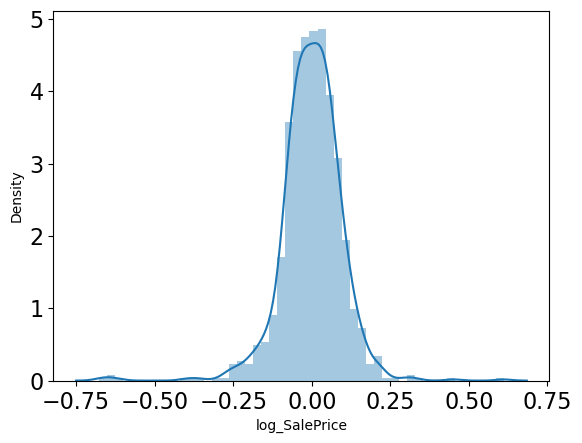

In [142]:
data= y_train['log_SalePrice'] - y_pred_lasso_train
sns.distplot(data)
plt.show()

## Ridge

In [87]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv_ridge = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True, 
                        verbose = 1)            

model_cv_ridge.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [89]:
# CV results
cv_results_ridge = pd.DataFrame(model_cv_ridge.cv_results_)
cv_results_ridge[['params', 'mean_train_score', 'mean_test_score']].head()

params  mean_train_score  mean_test_score
0  {'alpha': 0.0001}         -0.060447        -0.106230
1   {'alpha': 0.001}         -0.060447        -0.106227
2    {'alpha': 0.01}         -0.060449        -0.106203
3    {'alpha': 0.05}         -0.060458        -0.106102
4     {'alpha': 0.1}         -0.060475        -0.106007

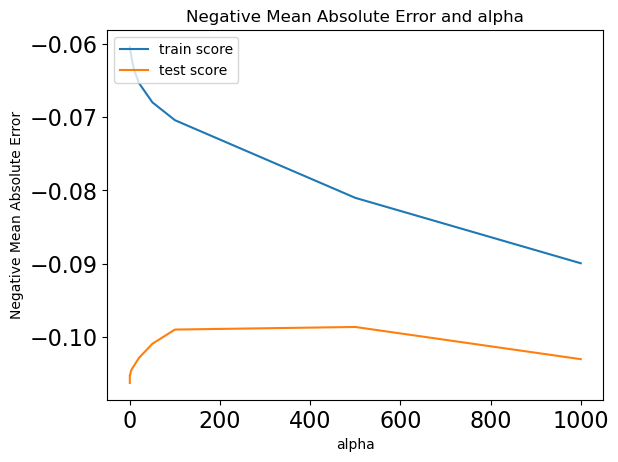

In [90]:
# plotting mean test and train scores with alpha 
cv_results_ridge['param_alpha'] = cv_results_ridge['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_train_score'])
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [91]:
# Best alpha value
model_cv_ridge.best_params_

{'alpha': 500}

In [143]:
# Ridge Model for best param
ridge = Ridge(alpha=model_cv_ridge.best_params_['alpha'])
ridge.fit(X_train, y_train)

y_pred_ridge_train=ridge.predict(X_train)
print('Train R2 Square : ', round(r2_score(y_train, y_pred_ridge_train),2))

y_pred_ridge_test=ridge.predict(X_test)
print('Test R2 Square : ', round(r2_score(y_test, y_pred_ridge_test),2))



Train R2 Square :  0.91
Test R2 Square :  0.89


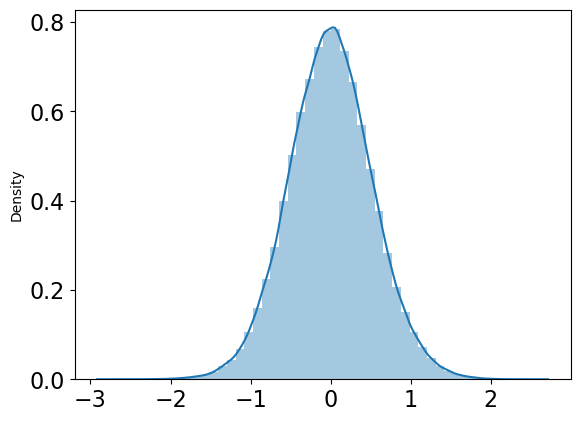

In [151]:
data_ridge= list(y_train['log_SalePrice']) - y_pred_ridge_train
sns.distplot(data_ridge)
plt.show()